In [1]:
# Imports
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sentence_transformers import SentenceTransformer
import re

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import shutil
import os

os.makedirs('data/processed', exist_ok=True)

# Copy from Drive to Colab
!cp /content/drive/MyDrive/stat362_data/*.npy data/processed/
!cp /content/drive/MyDrive/stat362_data/*.pkl data/processed/

# Verify
!ls -lh data/processed/

total 37M
-rw------- 1 root root  164 Dec  9 15:21 class_weights.pkl
-rw------- 1 root root 3.6M Dec  9 15:21 X_test_text.npy
-rw------- 1 root root  29M Dec  9 15:21 X_train_text.npy
-rw------- 1 root root 3.5M Dec  9 15:21 X_val_text.npy
-rw------- 1 root root  79K Dec  9 15:21 y_test.npy
-rw------- 1 root root 626K Dec  9 15:21 y_train.npy
-rw------- 1 root root  79K Dec  9 15:21 y_val.npy


In [4]:
# Load Data
X_train_text_full = np.load('data/processed/X_train_text.npy', allow_pickle=True)
X_val_text = np.load('data/processed/X_val_text.npy', allow_pickle=True)
X_test_text = np.load('data/processed/X_test_text.npy', allow_pickle=True)

y_train_full = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Sample 30,000 for training
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_text_full), 30000, replace=False)
X_train_text = X_train_text_full[sample_idx]
y_train = y_train_full[sample_idx]

# Recompute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print(f"Train: {len(X_train_text)}, Val: {len(X_val_text)}, Test: {len(X_test_text)}")

Train: 30000, Val: 10000, Test: 10000


In [5]:
# Tokenization and sequence
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return [w for w in text.split() if w]

def create_sequences(texts, max_length=50):
    sequences = []
    for text in texts:
        tokens = simple_tokenize(text)
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
        else:
            tokens = tokens + [''] * (max_length - len(tokens))
        sequences.append(tokens)
    return np.array(sequences, dtype=object)

MAX_SEQ_LENGTH = 50

train_sequences = create_sequences(X_train_text, MAX_SEQ_LENGTH)
val_sequences = create_sequences(X_val_text, MAX_SEQ_LENGTH)
test_sequences = create_sequences(X_test_text, MAX_SEQ_LENGTH)

print(f"Sequence shape: {train_sequences.shape}")

Sequence shape: (30000, 50)


In [6]:
# word-level embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
EMBEDDING_DIM = 384

def sequences_to_embeddings(token_sequences, batch_size=1000):
    n_samples, seq_len = token_sequences.shape

    all_tokens = set()
    for seq in token_sequences:
        all_tokens.update([tok for tok in seq if tok])

    all_tokens = list(all_tokens)

    token_embeddings = embedding_model.encode(
        all_tokens, batch_size=batch_size, show_progress_bar=False, convert_to_numpy=True
    )

    token_to_embedding = {token: emb for token, emb in zip(all_tokens, token_embeddings)}
    zero_embedding = np.zeros(EMBEDDING_DIM)

    embedding_sequences = np.zeros((n_samples, seq_len, EMBEDDING_DIM), dtype=np.float32)

    for i, seq in enumerate(token_sequences):
        for j, token in enumerate(seq):
            embedding_sequences[i, j] = token_to_embedding[token] if token else zero_embedding
    return embedding_sequences

X_train_emb = sequences_to_embeddings(train_sequences)
X_val_emb = sequences_to_embeddings(val_sequences)
X_test_emb = sequences_to_embeddings(test_sequences)
print(f"Embedding shape: {X_train_emb.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Embedding shape: (30000, 50, 384)


In [7]:
# GRU Model
def create_gru_model(input_shape):
    model = keras.Sequential([
        layers.GRU(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.GRU(64),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

gru_model = create_gru_model(input_shape=(MAX_SEQ_LENGTH, EMBEDDING_DIM))
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           197376    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 9

In [8]:
# Train GRU
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history_gru = gru_model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/50
938/938 [==============================] - 20s 15ms/step - loss: 1.0895 - accuracy: 0.5329 - val_loss: 1.0991 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - loss: 0.9346 - accuracy: 0.5947 - val_loss: 0.8342 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 11s 12ms/step - loss: 0.8222 - accuracy: 0.6591 - val_loss: 0.8228 - val_accuracy: 0.6263 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 11s 12ms/step - loss: 0.7761 - accuracy: 0.6748 - val_loss: 0.6494 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 12s 13ms/step - loss: 0.7421 - accuracy: 0.6950 - val_loss: 0.5976 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 6/50
938/938 [==============================] - 11s 12ms/step - loss: 0.7197 - accuracy: 0.7083 - val_loss: 0.6317 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 7/50
938/938 [==============================] - 11s 

In [9]:
# Evaluate GRU
test_loss, test_acc = gru_model.evaluate(X_test_emb, y_test, verbose=0)
y_pred_gru = np.argmax(gru_model.predict(X_test_emb, verbose=0), axis=1)
f1_gru = f1_score(y_test, y_pred_gru, average='macro')

print(f"GRU Test Accuracy: {test_acc*100:.2f}%")
print(f"GRU Macro F1: {f1_gru:.4f}\n")
print(classification_report(y_test, y_pred_gru, target_names=['Negative', 'Neutral', 'Positive']))

GRU Test Accuracy: 73.10%
GRU Macro F1: 0.5926

              precision    recall  f1-score   support

    Negative       0.60      0.67      0.63      1463
     Neutral       0.20      0.55      0.30       829
    Positive       0.96      0.76      0.85      7708

    accuracy                           0.73     10000
   macro avg       0.59      0.66      0.59     10000
weighted avg       0.85      0.73      0.77     10000



In [10]:
# Save GRU results
Path('models').mkdir(exist_ok=True)
Path('results/metrics').mkdir(parents=True, exist_ok=True)

gru_model.save('models/gru_best.keras')

gru_results = {
    'model': 'GRU',
    'test_accuracy': float(gru_model.evaluate(X_test_emb, y_test, verbose=0)[1]),
    'macro_f1': float(f1_gru),
    'parameters': int(gru_model.count_params())
}

with open('results/metrics/gru_results.json', 'w') as f:
    json.dump(gru_results, f, indent=2)

# Copy to Google Drive so it persists
!cp models/gru_best.keras /content/drive/MyDrive/stat362_data/
!cp results/metrics/gru_results.json /content/drive/MyDrive/stat362_data/

print("GRU saved to Drive!")

GRU saved to Drive!


In [12]:
# Save GRU history (convert numpy to python floats)
gru_history_data = {
    'loss': [float(x) for x in history_gru.history['loss']],
    'val_loss': [float(x) for x in history_gru.history['val_loss']],
    'accuracy': [float(x) for x in history_gru.history['accuracy']],
    'val_accuracy': [float(x) for x in history_gru.history['val_accuracy']]
}

with open('results/metrics/gru_history.json', 'w') as f:
    json.dump(gru_history_data, f)

!cp results/metrics/gru_history.json /content/drive/MyDrive/stat362_data/

print("GRU history saved!")

GRU history saved!


In [13]:
# Clear memory
import gc
del gru_model
del history_gru
gc.collect()
tf.keras.backend.clear_session()

In [14]:
# Bidirectional GRU Model
def create_bigru_model(input_shape):
    model = keras.Sequential([
        layers.Bidirectional(layers.GRU(128, return_sequences=True), input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.GRU(64)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

bigru_model = create_bigru_model(input_shape=(MAX_SEQ_LENGTH, EMBEDDING_DIM))
bigru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 50, 256)           394752    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               123648    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [15]:
# Train Bi-GRU
history_bigru = bigru_model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30
938/938 [==============================] - 28s 21ms/step - loss: 0.9589 - accuracy: 0.5435 - val_loss: 0.6057 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 2/30
938/938 [==============================] - 17s 18ms/step - loss: 0.8248 - accuracy: 0.6534 - val_loss: 0.7897 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/30
938/938 [==============================] - 18s 19ms/step - loss: 0.7675 - accuracy: 0.6879 - val_loss: 0.6447 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 4/30
938/938 [==============================] - 17s 18ms/step - loss: 0.7398 - accuracy: 0.7046 - val_loss: 0.6332 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 5/30
938/938 [==============================] - 16s 18ms/step - loss: 0.7078 - accuracy: 0.7205 - val_loss: 0.6204 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 6/30
938/938 [==============================] - 17s 18ms/step - loss: 0.6814 - accuracy: 0.7232 - val_loss: 0.6354 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 7/30
938/938 [==============================] - 17s 

In [16]:
# Evaluate Bi-GRU
test_loss, test_acc = bigru_model.evaluate(X_test_emb, y_test, verbose=0)
y_pred_bigru = np.argmax(bigru_model.predict(X_test_emb, verbose=0), axis=1)
f1_bigru = f1_score(y_test, y_pred_bigru, average='macro')

print(f"Bi-GRU Test Accuracy: {test_acc*100:.2f}%")
print(f"Bi-GRU Macro F1: {f1_bigru:.4f}\n")
print(classification_report(y_test, y_pred_bigru, target_names=['Negative', 'Neutral', 'Positive']))

Bi-GRU Test Accuracy: 76.20%
Bi-GRU Macro F1: 0.6083

              precision    recall  f1-score   support

    Negative       0.61      0.66      0.64      1463
     Neutral       0.23      0.52      0.31       829
    Positive       0.95      0.81      0.87      7708

    accuracy                           0.76     10000
   macro avg       0.60      0.66      0.61     10000
weighted avg       0.84      0.76      0.79     10000



In [22]:
# Comparison (load GRU results from saved file)
with open('results/metrics/gru_results.json', 'r') as f:
    gru_results = json.load(f)

comparison = pd.DataFrame({
    'Model': ['GRU', 'Bi-GRU'],
    'Test Accuracy (%)': [
        gru_results['test_accuracy'] * 100,
        bigru_model.evaluate(X_test_emb, y_test, verbose=0)[1] * 100
    ],
    'Macro F1': [gru_results['macro_f1'], f1_bigru],
    'Parameters': [gru_results['parameters'], bigru_model.count_params()]
})

print(comparison.to_string(index=False))

 Model  Test Accuracy (%)  Macro F1  Parameters
   GRU          73.100001  0.592558      236803
Bi-GRU          76.200002  0.608334      522627


In [24]:
# Copy files back from Drive
!cp /content/drive/MyDrive/stat362_data/gru_history.json results/metrics/
!cp /content/drive/MyDrive/stat362_data/gru_results.json results/metrics/

print("Files copied!")

Files copied!


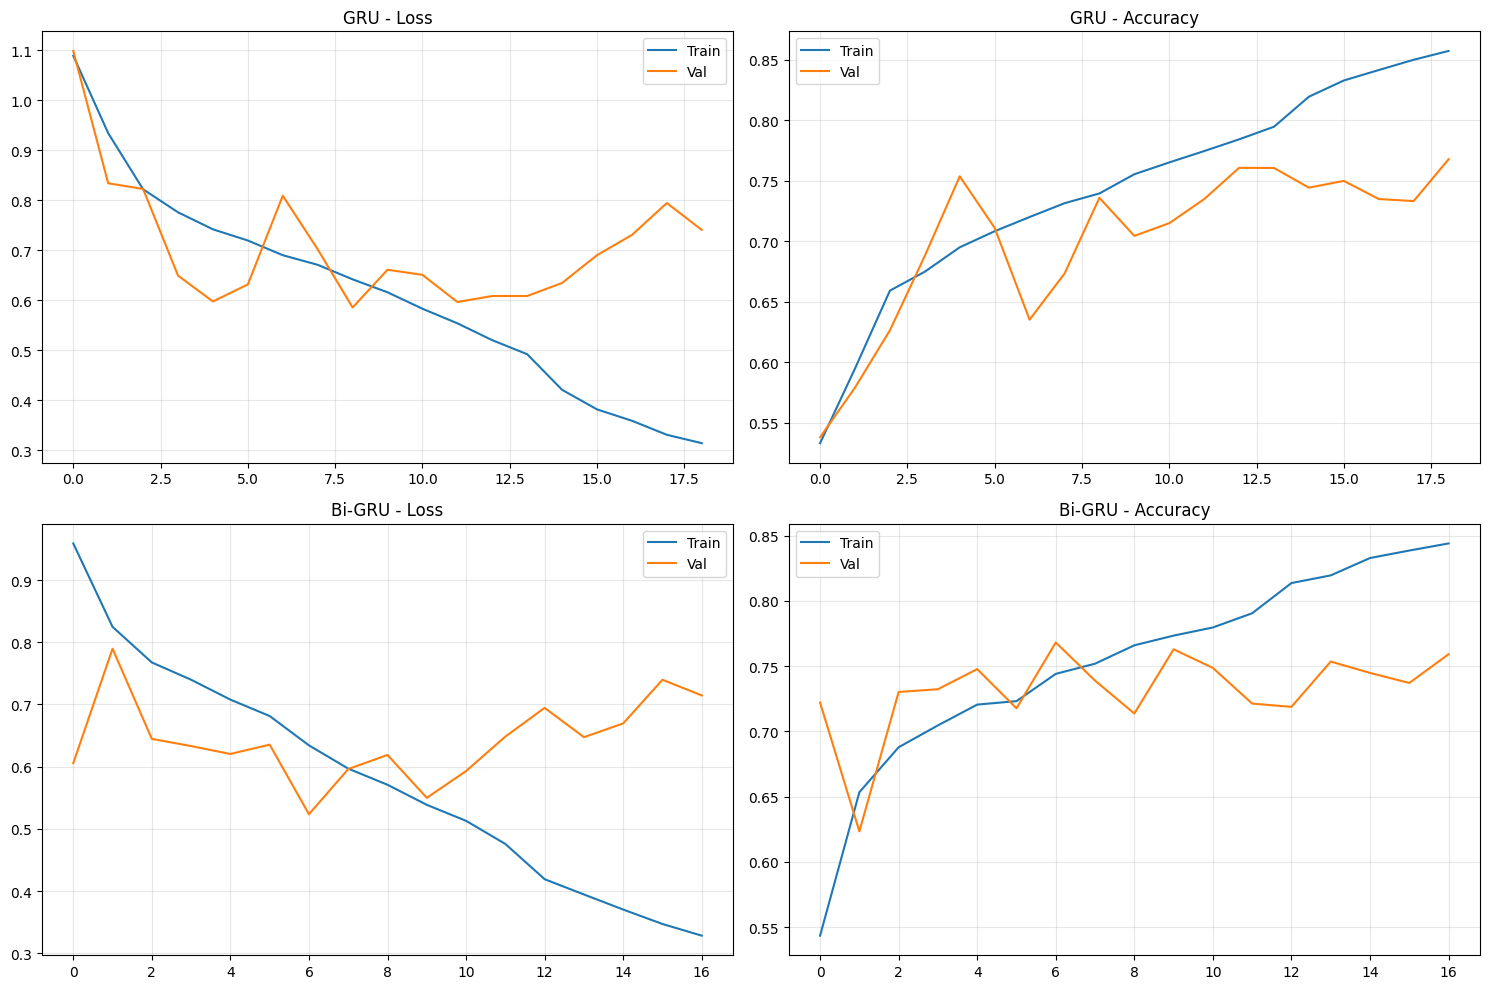

In [26]:
# Training Curves
with open('results/metrics/gru_history.json', 'r') as f:
    gru_history = json.load(f)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(gru_history['loss'], label='Train')
axes[0, 0].plot(gru_history['val_loss'], label='Val')
axes[0, 0].set_title('GRU - Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(gru_history['accuracy'], label='Train')
axes[0, 1].plot(gru_history['val_accuracy'], label='Val')
axes[0, 1].set_title('GRU - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history_bigru.history['loss'], label='Train')
axes[1, 0].plot(history_bigru.history['val_loss'], label='Val')
axes[1, 0].set_title('Bi-GRU - Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(history_bigru.history['accuracy'], label='Train')
axes[1, 1].plot(history_bigru.history['val_accuracy'], label='Val')
axes[1, 1].set_title('Bi-GRU - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
Path('results/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('results/figures/gru_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

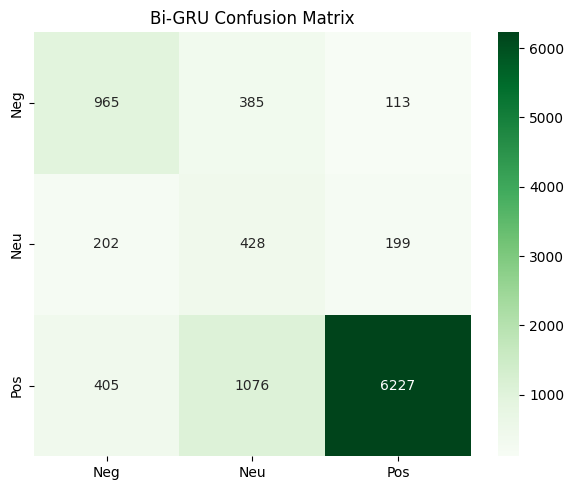

In [27]:
# Confusion Matrix (Bi-GRU)
fig, ax = plt.subplots(figsize=(6, 5))

cm_bigru = confusion_matrix(y_test, y_pred_bigru)
sns.heatmap(cm_bigru, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neg', 'Neu', 'Pos'],
            yticklabels=['Neg', 'Neu', 'Pos'], ax=ax)
ax.set_title('Bi-GRU Confusion Matrix')

plt.tight_layout()
plt.savefig('results/figures/bigru_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Save Bi-GRU Results
Path('models').mkdir(exist_ok=True)
Path('results/metrics').mkdir(parents=True, exist_ok=True)

bigru_model.save('models/bigru_best.keras')

bigru_results = {
    'model': 'Bi-GRU',
    'test_accuracy': float(bigru_model.evaluate(X_test_emb, y_test, verbose=0)[1]),
    'macro_f1': float(f1_bigru),
    'parameters': int(bigru_model.count_params())
}

with open('results/metrics/bigru_results.json', 'w') as f:
    json.dump(bigru_results, f, indent=2)

# Copy to Drive
!cp models/bigru_best.keras /content/drive/MyDrive/stat362_data/
!cp results/metrics/bigru_results.json /content/drive/MyDrive/stat362_data/
